# NPFE Classification

This notebook supports the detection and description of new particle formation events (NPFEs) that may have occurred on specific days and places. 

Start by setting up the notebook. First, you need to provide your gcube token and load the provided functions. Then you can start analysing days (YYYY-MM-DD) and places (Hyytiaelae).

## Setup

In [215]:
import os

# In the Terminal, export GCUBE_TOKEN=''
gcube_token = os.environ['GCUBE_TOKEN']
# Alternatively, include the token here
# gcube_token = ''

In [216]:
import logging
from io import BytesIO
from lxml import etree as et
from IPython.display import Image, display
from owslib.wps import WebProcessingService, ComplexDataInput, monitorExecution

logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)
dataminer_url = 'http://dataminer-prototypes.d4science.org/wps/WebProcessingService'
headers = {'gcube-token': gcube_token}
wps = WebProcessingService(dataminer_url, headers=headers)

def plot(day, place):
    identifier = 'org.gcube.dataanalysis.wps.statisticalmanager.synchserver.mappedclasses.transducerers.PFFETCHPLOTDATA'
    execution = wps.execute(identifier, [('day', day),('place', place)], output="non_deterministic_output")
    monitorExecution(execution, sleepSecs=5, download=False)
    output = execution.processOutputs[0]
    doc = et.parse(BytesIO(output.retrieveData(headers=headers)))
    return doc.xpath('/ogr:FeatureCollection/gml:featureMember/ogr:Result/d4science:Description[text() = "plot"]/../d4science:Data/text()', namespaces={
        'ogr': 'http://ogr.maptools.org/',
        'gml': 'http://www.opengis.net/gml',
        'd4science': 'http://www.d4science.org'
    })[0]

def visualize(image):
    display(Image(url=image, format='png', embed=True))
        
def record(day, place, beginning, end, classification):
    identifier = 'org.gcube.dataanalysis.wps.statisticalmanager.synchserver.mappedclasses.transducerers.PFRECORDDESCRIPTION'
    execution = wps.execute(identifier, [('day', day),('place', place),('beginning', beginning),('end', end),('classification', classification),('image', image)])

## Classification

In this section you can detect and describe NPFEs. We use primary data, specifically particle size distribution observational data, visualize primary data to detect and describe NPFEs. A specific task here is to classify events. Recording event descriptions automatically catalogues corresponding data files, as RDF data in Turtle syntax.

In [220]:
# Event days (Class Ia)
# 2007-04-15, 2007-05-05, 2007-05-18, 2007-10-19, 2008-02-19, 2009-03-19, 2009-03-22 
# 2011-03-15, 2011-04-19, 2011-10-01, 2012-05-01, 2012-05-29, 2013-02-20, 2013-04-04
#
# Non Event days
# 2007-04-20, 2008-02-20, 2009-04-03, 2011-04-21, 2012-05-05, 2013-02-21

day = '2013-04-04'
place = 'Hyytiaelae'

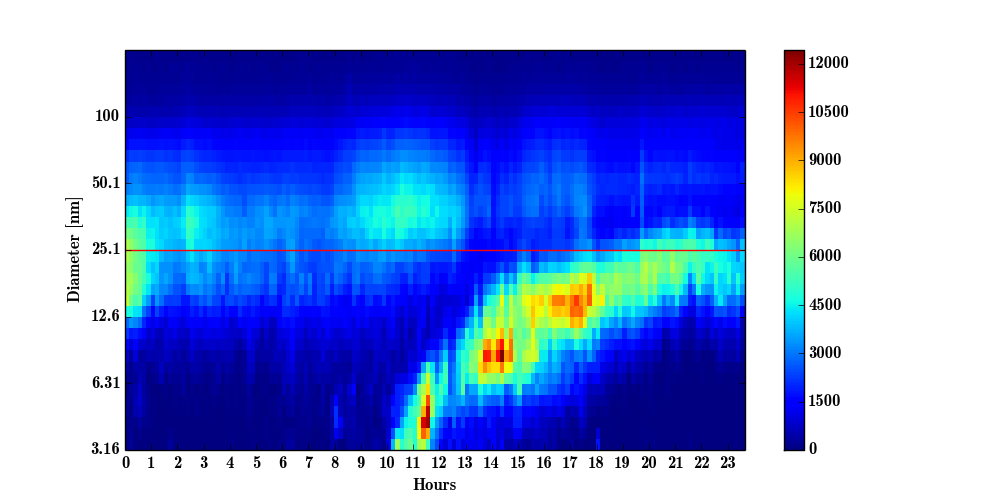

In [221]:
image = plot(day, place)
visualize(image)

In [222]:
record(day, place, '10:00', '12:00', 'Class Ia')